## IBDigital Open Question Analysis
This notebook presents an analysis of answers from IBDigital Questionnaire of the following questions:  
1. Reason of flare-ups? Would it help you to know in advance that you are going to have a flare-up? Explain why (not).  
2. What should a wearable not do? DO you have any ideas what a wearable should look like?  

We use topic models to anlayze frequency of answers.

### Data Preprocessing

In [1]:
# load data
import pandas as pd
data = pd.read_excel("data/DataSet_WP2_Excel.xlsx")
# display column BB to BD, and CF, DI
df = data.iloc[:, 53:56].join(data.iloc[:, 83:84]).join(data.iloc[:, 112:113])
df["Wish_predictability_flare"] = df["Wish_predictability_flare"].map({0: "Ja", 1: "Misschien", 2: "Nee"})
# check if there are line breakers in the text of all columns
for col in df.columns:
    if df[col].astype(str).str.contains('\n').any():
        print(f"Column {col} contains line breakers.")
        df[col] = df[col].str.replace('\n', ' ', regex=True)
# add ID column
df.insert(0, "ID", range(1, 1 + len(df)))
# save to csv
#df.to_csv("data/answers.csv", index=False)
# view dataframe
df.head()

Column Reason_flare contains line breakers.
Column Unwanted_features contains line breakers.
Column View_wearable contains line breakers.


,ID,Reason_flare,Wish_predictability_flare,Wish_predictability_because,Unwanted_features,View_wearable
0,1,Nee,Ja,minder klachten vooraf,geen extra belasting,smartwatch lijkt handig vrouwen hebben niet a...
1,2,Vroeger was dat bij stress,NaN,NaN,Ingewikkeld zijn.,Niet te groot en een mooi ontwerp
2,3,Het aan- of uitstaan van het familiaire coliti...,Ja,Dan kan ik mij AANMELDEN VOOR GERICHTE BEHANDE...,NaN,NaN
3,4,NaN,NaN,NaN,Bemoedigende woorden of tips geven die ik al 1...,Door het opvallend te maken is het meteen een ...
4,5,NaN,NaN,NaN,Aanwezig op de achtergrond ipv de voorgrond. T...,NaN


### Embed text
See embed_texts.py and embed.slurm

In [49]:
# load stopwords
with open("data/stopwords-nl.txt", "r") as f:
    stopwords = [line.strip() for line in f if line.strip()] # removed "geen" from stopwords

# remove "geen" from stopwords if present
if "geen" in stopwords:
    stopwords.remove("geen")

## 1. Unwanted Features

### 1.1 Load Data

In [45]:
# load embeddings and dfs
import numpy as np
import pandas as pd
embeddings_features = np.load("embeddings/emb_Unwanted_features.npy")
df_features = pd.read_csv("data/answers_for_embedding_Unwanted_features.csv")
texts_features = df_features["Unwanted_features"].astype(str).tolist()
print(f"Number of texts for Unwanted_features: {len(texts_features)}")
if embeddings_features.shape[0] != len(texts_features):
    raise ValueError("Number of embeddings does not match number of texts.")
# set colwidth to 200
pd.set_option('display.max_colwidth', 200)
df_features.head()

Number of texts for Unwanted_features: 860


,ID,Unwanted_features
0,1,geen extra belasting
1,2,Ingewikkeld zijn.
2,4,Bemoedigende woorden of tips geven die ik al 1000 keer gehoord of gelezen heb
3,5,Aanwezig op de achtergrond ipv de voorgrond. Te veel meldingen. Mij te veel confronteren met mijn ziekte.
4,6,periodiek gedurende de dag meldingen blijven geven zonder dat er iets aan de hand is. Veel meldingen met allerlei adviezen geven. Daar zou ik echt stress van krijgen waardoor het averechts werkt.


### 1.2 Clustering Embeddings with KMeans

In [50]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# --- 1. KMeans clustering on embeddings ---
num_clusters = 20
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings_features)
labels = kmeans.labels_

# add cluster labels to dataframe (df must align with embeddings_flare)
df_features["Cluster"] = labels

# group texts by cluster and concatenate them
cluster_docs = df_features.groupby("Cluster")["Unwanted_features"].apply(lambda x: " ".join(x)).tolist()


# --- 2. Build c-TF-IDF matrix on the original texts ---
# replace "text" with your actual column name
# Step 1: Create count matrix
vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(1,2))
count_matrix = vectorizer.fit_transform(cluster_docs)
vocab = np.array(vectorizer.get_feature_names_out())

# Step 2: Compute c-TF-IDF
# formula: tf * log(N / df)
term_freq = count_matrix.toarray()
df_term = np.sum(term_freq > 0, axis=0)  # number of clusters where term appears
N = len(term_freq)

ctfidf = term_freq * np.log(N / (df_term + 1e-10)) 

# --- 3. Extract top keywords for each cluster ---
def top_words_ctfidf(cluster_id, top_n=10):
    scores = ctfidf[cluster_id]
    top_idx = scores.argsort()[::-1][:top_n]
    return list(vocab[top_idx])   # subset TF-IDF rows for this cluster

cluster_keyword_dict = {
    c: ", ".join(top_words_ctfidf(c))
    for c in range(num_clusters)
}

# --- examples: existing + non-empty + non-duplicate per cluster ---
tmp = df_features[["Cluster", "Unwanted_features"]].copy()

# keep only valid strings
tmp["Unwanted_features"] = tmp["Unwanted_features"].astype(str)
tmp = tmp[tmp["Unwanted_features"].str.strip().ne("")]          # remove empty/whitespace
tmp = tmp[tmp["Unwanted_features"].str.lower().ne("nan")]       # remove "nan" strings if any

# remove duplicates within each cluster (keep first occurrence)
tmp = tmp.drop_duplicates(subset=["Cluster", "Unwanted_features"], keep="first")

# collect up to 3 examples per cluster
examples_list = (
    tmp.groupby("Cluster")["Unwanted_features"]
       .apply(lambda s: s.head(3).tolist())
)

# expand to 3 columns (pads with NaN if fewer than 3 unique examples exist)
examples = pd.DataFrame(
    examples_list.tolist(),
    index=examples_list.index,
    columns=["Example_answer_1", "Example_answer_2", "Example_answer_3"]
)

# merge (and keep clusters with 0 examples too)
cluster_info_features = pd.DataFrame({
    "Cluster": np.arange(num_clusters),
    "Cluster_Keywords_ctfidf": [cluster_keyword_dict.get(c, "") for c in range(num_clusters)],
    "Count": df_features["Cluster"].value_counts().reindex(range(num_clusters), fill_value=0).values,
}).merge(examples, left_on="Cluster", right_index=True, how="left")


# sort by count descending
cluster_info_features = cluster_info_features.sort_values(by="Count", ascending=False).reset_index(drop=True)


# set Cluster to int
df_features["Cluster"] = df_features["Cluster"].astype(int)

# compute tf-idf on the original texts for comparison
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_features["Unwanted_features"])
tfidf_vocab = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_array = tfidf_matrix.toarray()
def top_words_tfidf(doc_id, top_n=3):
    scores = tfidf_array[doc_id]
    top_idx = scores.argsort()[::-1][:top_n]
    return list(tfidf_vocab[top_idx])

df_features["TopKeywords_tfidf"] = [
    ", ".join(top_words_tfidf(i)) for i in range(len(df_features))
]

print("Cluster info based on c-TF-IDF:")    
display(cluster_info_features)

Cluster info based on c-TF-IDF:


,Cluster,Cluster_Keywords_ctfidf,Count,Example_answer_1,Example_answer_2,Example_answer_3
0,4,"meldingen, meldingen geven, teveel meldingen, meldingen teveel, meldingen ingewikkeld, gebruik meldingen, meldingen meldingen, geven meldingen, meldingen adviezen, zitten meldingen",114,"te veel meldingen, informatie elders opslaan",ingewikkeld en te veel meldingen,Teveel meldingen en sterss geven
1,10,"meldingen meldingen, meldingen, meldingen teveel, teveel meldingen, geven meldingen, meldingen geven, teveel, overbodige meldingen, teveel meldt, meldingen complex",93,Te veel meldingen,Teveel meldingen,Te veel meldingen geven
2,13,"meldingen, stress, geven meldingen, stress geven, meldingen ingewikkeld, meldingen stress, teveel meldingen, meldingen geven, stress stress, meldingen waardoor",65,Aanwezig op de achtergrond ipv de voorgrond. Te veel meldingen. Mij te veel confronteren met mijn ziekte.,periodiek gedurende de dag meldingen blijven geven zonder dat er iets aan de hand is. Veel meldingen met allerlei adviezen geven. Daar zou ik echt stress van krijgen waardoor het averechts werkt.,Stress geven door te veel meldingen of super ingewikkeld te zijn of niet duidelijk zijn.
3,0,"meldingen, melding, meldingen geven, teveel meldingen, instellen, krijgen, constant, dag, keer melding, melding krijgen",58,Het met informerend zijn op de momenten dat ik dat wil. Dus niet continu meldingen etc,Denk inderdaad te veel meldingen en te ingewikkeld. Dat maakt het gebruik ervan niet leuk en ga je hem sneller niet meer gebruiken.,Te snel waarschuwing terwijl het nog niet nodig is
4,6,"beperken, waarschuwen, tips, adviezen geven, invloed, tijd vragen, aanwezig, adviezen, reminders, betuttelen",55,Bemoedigende woorden of tips geven die ik al 1000 keer gehoord of gelezen heb,Te vaak te veel advies geven,Te veel aandacht eisen voor zaken die er niet toe doen.
5,7,"stress, signalen, stress geven, druk, informatie, waardoor, zorgen, geeft stress, geven informatie, stress geeft",50,stress veroorzaken. Onhandig/groot in gebruik.,Me niet oversensitief maken want dat geeft juist stress.,Vooral geen irritatie en/of stress geven
6,16,"bovenstaande, leven, kapot gaan, voorbeelden, kapot, beheersen, overnemen, belasting, zie, interesse moelijk",46,geen extra belasting,Mijn leven overnemen.,Wat hierboven staat
7,5,"ingewikkeld ingewikkeld, ingewikkeld, gebruik ingewikkeld, ingewikkeld bedienen, ingewikkeld aanwezig, bedienen ingewikkeld, aanwezig ingewikkeld, ingewikkeld ingewikkelde, ingewikkeld mee, ingewi...",44,Ingewikkeld zijn.,Ingewikkelde zijn,Ingewikkeld zijn
8,3,"smartwatch, watch, jaren, app, horloge, wearable, data, percentage, kreeg, garmin",42,Alleen doen waarvoor het bedoeld is en wil 'm niet altijd dragen. Zelf kunnen kiezen wanneer ik 'm omwil om iets bij te houden. Wil ook niet een volledige smart watch moeten aanschaffen hiervoor. ...,"Geen idee, heb nu ook een smartwatch en ben gewend aan de werking daarvan","Zie boven, vergelijk alle smartwatches die er zijn. Het heeft niet veel zin om 20 dingen ermee te kunnen of willen doen. Keep it simple, 3-4 hoofdindicatoren is al max. waarschijnlijk."
9,9,"moeilijk, moeilijk gebruik, dragen, eenvoudig, nacht dragen, eenvoudig gebruik, gebruik, batterijduur, moeilijk bedienen, makkelijk",42,"Ingewikkeld zijn, slechte batterijduur, niet spatwaterdicht zijn",makkelijk zijn voor jong en oud,Moet alles wel zelf kunnen instellen


In [57]:
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd

# IMPORTANT: make vocabulary a SORTED LIST
all_keywords = sorted(all_keywords)

vectorizer = CountVectorizer(
    vocabulary=all_keywords,
    binary=True,
    stop_words=stopwords
)

X = vectorizer.fit_transform(df_features["Unwanted_features"])

# get feature order used internally
features = vectorizer.get_feature_names_out()

co_occurrence_matrix = (X.T @ X).toarray()
co_occurrence_matrix = pd.DataFrame(
    co_occurrence_matrix,
    index=features,
    columns=features
)

# zero diagonal
np.fill_diagonal(co_occurrence_matrix.values, 0)



In [59]:
# co_occurrence_matrix: DataFrame (keywords x keywords)

# keep only upper triangle (avoid duplicates + diagonal)
upper = co_occurrence_matrix.where(
    np.triu(np.ones(co_occurrence_matrix.shape), k=1).astype(bool)
)

# turn into (word1, word2, count) table
pairs = (upper.stack()
              .reset_index())
pairs.columns = ["word_1", "word_2", "count"]

# top N pairs
top_n = 30
top_pairs = pairs.sort_values("count", ascending=False).head(top_n)

top_pairs


,word_1,word_2,count
11478,meldingen,teveel,83.0
11471,meldingen,stress,61.0
7960,ingewikkeld,meldingen,50.0
7993,ingewikkeld,stress,35.0
10057,kosten,tijd,31.0
13425,stress,teveel,27.0
5005,geen,stress,23.0
8000,ingewikkeld,teveel,22.0
2270,bezig,ziekte,19.0
4277,gebruik,meldingen,17.0


In [14]:
df_features.head(20)

,ID,Unwanted_features,Cluster,TopKeywords_tfidf
0,1,geen extra belasting,9,"geen extra, extra belasting, belasting"
1,2,Ingewikkeld zijn.,5,"ingewikkeld, geven meldingen, geven meerdere"
2,4,Bemoedigende woorden of tips geven die ik al 1000 keer gehoord of gelezen heb,8,"woorden, 1000 keer, gehoord gelezen"
3,5,Aanwezig op de achtergrond ipv de voorgrond. Te veel meldingen. Mij te veel confronteren met mijn ziekte.,0,"aanwezig achtergrond, achtergrond ipv, voorgrond meldingen"
4,6,periodiek gedurende de dag meldingen blijven geven zonder dat er iets aan de hand is. Veel meldingen met allerlei adviezen geven. Daar zou ik echt stress van krijgen waardoor het averechts werkt.,0,"dag meldingen, echt stress, allerlei adviezen"
5,7,Ingewikkelde zijn,5,"ingewikkelde, geven miet, geven meerdere"
6,8,Te vaak te veel advies geven,6,"advies geven, advies, geven"
7,9,Ingewikkeld zijn,5,"ingewikkeld, geven meldingen, geven meerdere"
8,11,"stress geven, te veel meldingen, ingewikkeld zijn, het enige als naslag raadplegen hoe het met de patient gaat. nog steeds persoonlijk contact lijkt me wel belangrijk",8,"patient gaat, patient, raadplegen patient"
9,12,"Stress opleveren, te veel een inbreuk zijn op mijn dagelijks leven. In periodes dat het goed gaat, wil ik liever niet met mijn ziekte bezig zijn.",8,"periodes goed, periodes, gaat ziekte"


In [54]:
# for the following 1-gram or 2-gram keywords, count the frequencies of answers containing each keyword with OR logic
words = [("melding", "geluid"), ("stress", ""), ("ingewikkeld", "moeilijk"), ("bovenstaand", "hierboven"), ("tijd", "kosten")]
# count frequencies
for word_tuple in words:
    if len(word_tuple) == 1:
        print(f"Processing single keyword: {word_tuple[0]}")
        keyword = word_tuple[0]
        pattern = word_tuple[0]
    else:
        keyword = " / ".join(word_tuple)
        pattern = "|".join(word_tuple)
    df_features[f"Contains_{keyword}"] = df_features["Unwanted_features"].str.contains(pattern, case=False, na=False).astype(int)
    count = df_features[f"Contains_{keyword}"].sum()
    print(f"Number of answers containing '{keyword}': {count}")

Number of answers containing 'melding / geluid': 356
Number of answers containing 's / t / r / e / s / s': 860
Number of answers containing 'ingewikkeld / moeilijk': 198
Number of answers containing 'bovenstaand / hierboven': 9
Number of answers containing 'tijd / kosten': 73


### Analysis 1. Topic Model for Reason_flare

In [43]:
# load embeddings
import numpy as np
import pandas as pd
embeddings_flare = np.load("embeddings/emb_Reason_flare.npy")
print(embeddings_flare.shape)
df_reason_flare = pd.read_csv("data/answers_for_embedding_Reason_flare.csv")
texts = df_reason_flare["Reason_flare"].astype(str).tolist()
print(len(texts))
pd.set_option('display.max_colwidth', 200)
df_reason_flare.head()

(598, 768)
598


,ID,Reason_flare
0,2,Vroeger was dat bij stress
1,3,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben
2,6,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voeds..."
3,8,"Nee, mijn ziekte was tot 4 jaar geleden 1 grote opvlamming"
4,12,"Bewerkte voeding, vlees, suikers, alcohol"


In [44]:
# check all entries starting with "nee" or "geen idee" in Reason_flare
df_reason_flare["Reason_flare"].str.contains(r"^(?:nee|geen idee)", case=False, na=False)
# get the index of these entries
indices_nee_geen_idee = df_reason_flare[df_reason_flare["Reason_flare"].str.contains(r"^(?:nee|geen idee)", case=False, na=False)].index.tolist()
# get a few samples of these entries
print("Entries starting with 'nee' or 'geen idee' are filtered out:")
df_reason_flare.loc[indices_nee_geen_idee].head(10)

Entries starting with 'nee' or 'geen idee' are filtered out:


,ID,Reason_flare
3,8,"Nee, mijn ziekte was tot 4 jaar geleden 1 grote opvlamming"
5,16,"Nee, ik heb hier geen idee over."
7,18,Nee daar kom ik nog niet achter
20,45,"Nee, helaas niet. Is altijd zeer onverwacht. Soms kan stress en verkeerde voeding een tijdelijk ongemak (max 1 dag) veroorzaken, maar een opvlamming kwam altijd onveracht."
23,48,"Nee, totaal willekeurig"
25,55,"Nee, het is volledig onverwacht"
42,82,Nee geen idee
44,85,Geen idee
50,97,Geen idee ontstaat plotseling en niet te verklaren
69,139,Nee het komt heel plots. Een week van tevoren voel ik nog geen signalen.


In [4]:
# get the rest as texts for clustering
# remove embeddings of entries with "nee" or "geen idee" based on the indices
embeddings_flare_filtered = np.delete(embeddings_flare, indices_nee_geen_idee, axis=0)
df_reason_flare_filtered = df_reason_flare.drop(index=indices_nee_geen_idee)
texts_filtered = df_reason_flare_filtered["Reason_flare"].astype(str).tolist()
print(embeddings_flare_filtered.shape)
print(len(texts_filtered))
df_reason_flare_filtered.head(30)

(511, 768)
511


,ID,Reason_flare
0,2,Vroeger was dat bij stress
1,3,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben
2,6,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voeds..."
4,12,"Bewerkte voeding, vlees, suikers, alcohol"
6,17,"Ja, stress en bepaald eten"
8,19,"Stress is duidelijke factor, verder kan ik het eigenlijk niet zeggen. Voelt random."
9,20,denk stress
10,22,Stress is sowieso voor mij een bepalende factor
11,26,"stress is zeker een factor die meespeelt, Rust en regelmaat helpt maar voorkomt geen opvlamming. Voedingsmiddelen kunnen een trigger zijn bij mij zoals koolsoorten, chocolade, witbrood, huzaren/ru..."
12,29,Stress wel denk ik


In [12]:
# print embeddings_flare_filtered first few entries
embeddings_flare_filtered[:5]

array([[-0.0368772 , -0.831615  ,  1.1809912 , ..., -0.7017132 ,
         0.8162674 ,  0.1162226 ],
       [-0.8532878 ,  0.38915187,  0.4587521 , ...,  0.61545503,
         1.0329407 , -0.08375264],
       [-0.73338825,  0.05558305,  0.36270118, ..., -0.5136405 ,
        -0.49527377, -0.10119979],
       [ 0.16054396, -0.0212942 ,  0.33072862, ..., -0.25436163,
        -0.16530222, -0.9310394 ],
       [-0.6847327 , -0.18983042,  0.3342399 , ..., -0.21225566,
        -0.03432192, -0.47791895]], dtype=float32)

##### Option 1: Embedding-based Clustering with K-Means

In [22]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# --- 1. KMeans clustering on embeddings ---
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(embeddings_flare_filtered)
labels = kmeans.labels_

# add cluster labels to dataframe (df must align with embeddings_flare)
df_reason_flare_filtered["Cluster"] = labels

# group texts by cluster and concatenate them
cluster_docs = df_reason_flare_filtered.groupby("Cluster")["Reason_flare"].apply(lambda x: " ".join(x)).tolist()


# --- 2. Build c-TF-IDF matrix on the original texts ---
# replace "text" with your actual column name
# Step 1: Create count matrix
vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(1,2))
count_matrix = vectorizer.fit_transform(cluster_docs)
vocab = np.array(vectorizer.get_feature_names_out())

# Step 2: Compute c-TF-IDF
# formula: tf * log(N / df)
term_freq = count_matrix.toarray()
df_term = np.sum(term_freq > 0, axis=0)  # number of clusters where term appears
N = len(term_freq)

ctfidf = term_freq * np.log(N / (df_term + 1e-10)) 

# --- 3. Extract top keywords for each cluster ---
def top_words_ctfidf(cluster_id, top_n=10):
    scores = ctfidf[cluster_id]
    top_idx = scores.argsort()[::-1][:top_n]
    return list(vocab[top_idx])   # subset TF-IDF rows for this cluster

cluster_keyword_dict = {
    c: ", ".join(top_words_ctfidf(c))
    for c in range(num_clusters)
}

df_reason_flare_filtered["ClusterKeywords_ctfidf"] = df_reason_flare_filtered["Cluster"].map(cluster_keyword_dict)




# set colwidth to max
pd.set_option('display.max_colwidth', None)
# set max rows to display
pd.set_option('display.max_rows', 30)
# join the filtered df with the geen idee entries for final output
df_complete = pd.concat([df_reason_flare.loc[indices_nee_geen_idee], df_reason_flare_filtered], ignore_index=False)
# for all "nee_geen" entries, set cluster to 0 and copy the ClusterKeywords_ctfidf from cluster 0
df_complete.loc[indices_nee_geen_idee, "Cluster"] = 0
df_complete.loc[indices_nee_geen_idee, "ClusterKeywords_ctfidf"] = cluster_keyword_dict[0]
df_complete.sort_index(inplace=True)
# set Cluster to int
df_complete["Cluster"] = df_complete["Cluster"].astype(int)

# now compute tf-idf on the original texts for comparison
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords, ngram_range=(1,2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df_complete["Reason_flare"])
tfidf_vocab = np.array(tfidf_vectorizer.get_feature_names_out())
tfidf_array = tfidf_matrix.toarray()
def top_words_tfidf(doc_id, top_n=3):
    scores = tfidf_array[doc_id]
    top_idx = scores.argsort()[::-1][:top_n]
    return list(tfidf_vocab[top_idx])

df_complete["TopKeywords_tfidf"] = [
    ", ".join(top_words_tfidf(i)) for i in range(len(df_complete))
]

df_complete[df_complete.columns[-4:]].head(30)  # display last 4 columns

,Reason_flare,Cluster,ClusterKeywords_ctfidf,TopKeywords_tfidf
0,Vroeger was dat bij stress,6,"stress stress, stress gerelateerd, stress, stress langdurige, langdurige, gerelateerd, stress extreme, drukte werk, stress lange, extreme","vroeger, vroeger stress, stress"
1,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben,3,"darm, crohn, operatie, verkoudheid, infectie, angstige, hormonen, colitis, griep, waardoor","crohn gen, familiaire, allemaal"
2,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voedsel met bijv. bestrijdingsmiddelen en toevoegingen niet gezond zijn en een trigger kunnen zijn. Vermijden is lastig.",8,"voeding stress, voeding, stress voeding, stress bepaalde, bepaalde voeding, eten, stress, stress eten, eten stress, vet","zaken, trigger, financiële zaken"
3,"Nee, mijn ziekte was tot 4 jaar geleden 1 grote opvlamming",0,"helaas weet, denk weet, wist, geen idee, weet geen, helaas, helaas echt, wou wist, bovenstaande geen, bovenstaande","grote opvlamming, ziekte jaar, jaar grote"
4,"Bewerkte voeding, vlees, suikers, alcohol",4,"voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden","vlees suikers, suikers alcohol, bewerkte voeding"
5,"Nee, ik heb hier geen idee over.",0,"helaas weet, denk weet, wist, geen idee, weet geen, helaas, helaas echt, wou wist, bovenstaande geen, bovenstaande","geen idee, idee, geen"
6,"Ja, stress en bepaald eten",8,"voeding stress, voeding, stress voeding, stress bepaalde, bepaalde voeding, eten, stress, stress eten, eten stress, vet","stress eten, eten, stress"
7,Nee daar kom ik nog niet achter,0,"helaas weet, denk weet, wist, geen idee, weet geen, helaas, helaas echt, wou wist, bovenstaande geen, bovenstaande","kom, hormonen menstruatie, hormonen hormoontherapie"
8,"Stress is duidelijke factor, verder kan ik het eigenlijk niet zeggen. Voelt random.",2,"stress, factor, factor stress, stress denk, drukte stress, mee stress, triggers stress, stress fodmaps, stress overbelasting, rol stress","factor zeggen, random, zeggen voelt"
9,denk stress,9,"stress denk, stress grootste, stress, weten, oorzaak weet, stress stress, denk stress, grootste, factor stress, onbewuste","denk stress, denk, stress"


In [20]:
# value conunts of clusters
df_complete["Cluster"].value_counts().sort_index()

Cluster
0    118
1     28
2     79
3     54
4     48
5     42
6     44
7     65
8     74
9     46
Name: count, dtype: int64

In [24]:
# sort the dataframe by cluster and make a new df with cluster and c-tf-idf keywords and texts in each cluster
df_sorted = df_reason_flare_filtered.sort_values(by="Cluster")
df_clustered = df_sorted[["Cluster", "Reason_flare", "ClusterKeywords_ctfidf"]]
df_clustered[df_clustered["Cluster"] == 4].head(30)

,Cluster,Reason_flare,ClusterKeywords_ctfidf
243,4,"Eten van suikers, werk (leerkracht basisonderwijs)","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
184,4,"stress, te veel hooi op de vork","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
238,4,"Rood vlees, rauwe vis","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
235,4,Ik denk het eten van VEEL vlees.,"voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
220,4,"stress, per ongeluk verkeerde voeding genomen.","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
136,4,Stress en voeding: verse groenten in de zomer. Rauwe groenten,"voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
274,4,"Bepaalde voeding; granen, suiker en bewerkt voedsel","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
480,4,"Voeding (italiaanse kruiden, tomaten) Stress (zorgen maken)","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
413,4,"Voeding: lactose, gluten en varkensvlees Voorheen stress, sinds infuus nu 5 jaar geen opvlamming","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"
409,4,"stress, minder goede voeding tijdens vakantie","voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden"


In [28]:
# calculate 2D UMAP embeddings for visualization
import umap
reducer = umap.UMAP(random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_flare)
df_complete["UMAP_1"] = embeddings_2d[:, 0]
df_complete["UMAP_2"] = embeddings_2d[:, 1]
df_complete

/home/jzhang/.local/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


,ID,Reason_flare,Cluster,ClusterKeywords_ctfidf,TopKeywords_tfidf,UMAP_1,UMAP_2
0,2,Vroeger was dat bij stress,6,"stress stress, stress gerelateerd, stress, stress langdurige, langdurige, gerelateerd, stress extreme, drukte werk, stress lange, extreme","vroeger, vroeger stress, stress",4.348538,4.413283
1,3,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben,3,"darm, crohn, operatie, verkoudheid, infectie, angstige, hormonen, colitis, griep, waardoor","crohn gen, familiaire, allemaal",5.046674,7.757788
2,6,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voedsel met bijv. bestrijdingsmiddelen en toevoegingen niet gezond zijn en een trigger kunnen zijn. Vermijden is lastig.",8,"voeding stress, voeding, stress voeding, stress bepaalde, bepaalde voeding, eten, stress, stress eten, eten stress, vet","zaken, trigger, financiële zaken",3.630026,8.721742
3,8,"Nee, mijn ziekte was tot 4 jaar geleden 1 grote opvlamming",0,"helaas weet, denk weet, wist, geen idee, weet geen, helaas, helaas echt, wou wist, bovenstaande geen, bovenstaande","grote opvlamming, ziekte jaar, jaar grote",6.193359,8.190514
4,12,"Bewerkte voeding, vlees, suikers, alcohol",4,"voeding, vlees, eten, bepaalde voeding, voedsel, vork, hooi, hooi vork, gluten, kruiden","vlees suikers, suikers alcohol, bewerkte voeding",2.422563,10.387647
...,...,...,...,...,...,...,...
593,1071,"Stress, onregelmatig eten, te veel en landurig inspannen en onstekingen die vooraf gaan zoals blaasontsteking",3,"darm, crohn, operatie, verkoudheid, infectie, angstige, hormonen, colitis, griep, waardoor","landurig, inspannen, blaasontsteking",3.133738,8.477818
594,1075,"Stress, antibiotica",1,"medicatie, stress antibiotica, medicijnen, medicatie stress, werkt stress, medicijn, medicatie werkt, voldoende, werkt, antibiotica","stress antibiotica, antibiotica, stress",3.782662,7.304381
595,1076,Reden is geweest een coronabesmetting en daarna dat medicatie toch niet voldoende blijkt te werken,1,"medicatie, stress antibiotica, medicijnen, medicatie stress, werkt stress, medicijn, medicatie werkt, voldoende, werkt, antibiotica","blijkt, reden coronabesmetting, blijkt werken",5.358102,7.289417
596,1077,Stress fodmaps,2,"stress, factor, factor stress, stress denk, drukte stress, mee stress, triggers stress, stress fodmaps, stress overbelasting, rol stress","stress fodmaps, fodmaps, stress",1.690995,5.604289


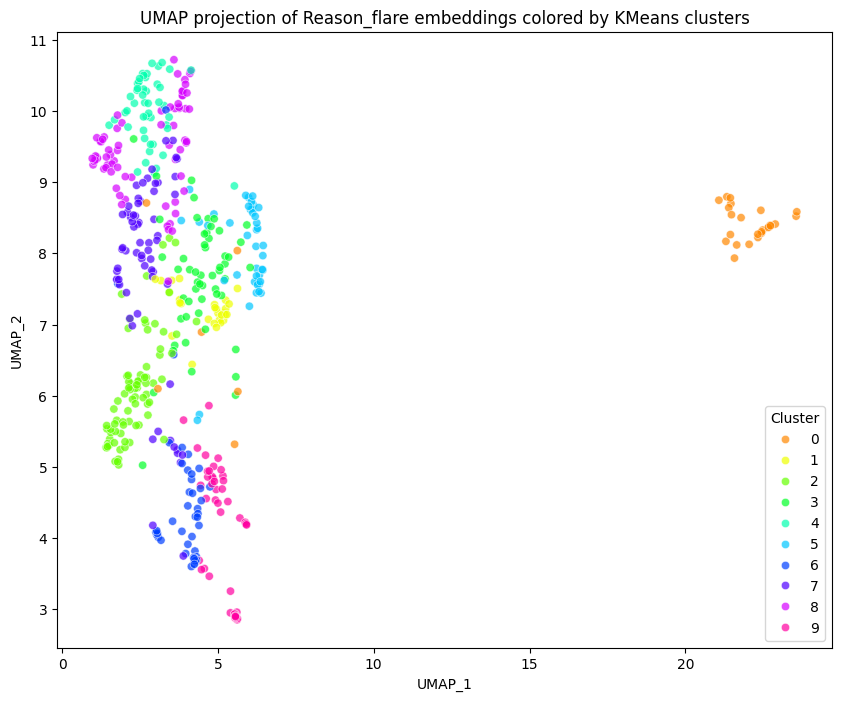

In [30]:
# plot UMAP with clusters
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 8))
filtered_indices = df_reason_flare_filtered.index
sns.scatterplot(
    x="UMAP_1", y="UMAP_2",
    hue="Cluster",
    palette=sns.color_palette("hsv", n_colors=num_clusters),
    data=df_complete.loc[filtered_indices],
    legend="full",
    alpha=0.7
)
plt.title("UMAP projection of Reason_flare embeddings colored by KMeans clusters")
plt.show()

In [35]:
from bertopic import BERTopic
from hdbscan import HDBSCAN
from umap import UMAP
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

# initialize BERTopic model

model = BERTopic(
    calculate_probabilities=False,
    verbose=True
)


model.vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=stopwords
)


model.umap_model = UMAP(
    n_neighbors=5,
    n_components=5,
    metric='euclidean',
    random_state=42
)


model.hdbscan_model = HDBSCAN(
    min_cluster_size=10,
    min_samples=2,
    metric='euclidean',
    cluster_selection_method='eom',
    prediction_data=True
)

# fit the model
topics, probs = model.fit_transform(texts_filtered, embeddings_flare_filtered)


2025-12-11 10:27:49,902 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-11 10:27:50,661 - BERTopic - Dimensionality - Completed ✓
2025-12-11 10:27:50,663 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-11 10:27:50,680 - BERTopic - Cluster - Completed ✓
2025-12-11 10:27:50,683 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-11 10:27:50,717 - BERTopic - Representation - Completed ✓


#### Option 2: BERTopic model with UMAP and HDBSCAN

In [36]:
model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,63,-1_stress_rust_periode_tijd,"[stress, rust, periode, tijd, eten, stress gekruid, zorgen, soms, stress gerelateerd, stress voeding]","[Stress of juist rust na een stressvolle periode. Dan komt het dus door stress, alleen het vlamt op als ik vakantie krijg., Stress, het normale leven (is al uitdagend ) en daarbij een stressvolle situatie die je niet kan voorzien. Die combinatie zorgt dat je in paniek schiet want een opvlamming ?komt nooit uit?. Nog meer stress, je blijft in een cirkeltje draaien van angst, paniek, pijn, ongeduld, veel tijd met wachten/bellen/bezoeken ziekenhuis?. Kortom dat helpt niet totdat je op een gegeven moment accepteert dat je echt ziek bent en even alles loslaat., Als ik heel druk ben, en zorgen heb, slecht slaap, dan kan dat zorgen voor gevoelige periode. Komt vaak door kinderen die een periode minder slapen, soms meerdere keren per nacht wakker worden om het een of ander en dan ook mijn nacht opknippen. Als dit zich combineert met een paar lastige zaken op het werk waardoor ik al wat minder rust heb, kan dat zorgen voor lichamelijk kwetsbare periode. Tijdens intensief hardlopen, of periode van intensieve training/wedstrijd, kan ook een kwetsbare tijd ontstaan. Dat moet dan ook niet te lang duren. Voor bepaalde voeding (melkproducten) ben ik gevoelig, en die hebben een directe uitwerking op mijn ontlasting, samenstelling en frequentie, maar dat is na een dag wel weer voorbij. Het zorgt niet voor een opvlamming in mijn beleving.]"
1,0,90,0_voeding_stress_bepaalde_voeding stress,"[voeding, stress, bepaalde, voeding stress, bepaalde voeding, stress bepaalde, eten, stress voeding, soms, hooi vork]","[Stress, bepaalde voeding,, Bepaalde voeding en stress, Stress en bepaalde voeding maar vooral stress]"
2,1,75,1_stress_factor_invloed_factor stress,"[stress, factor, invloed, factor stress, triggers, stress denk, grote, triggers stress, stress grote, denk]","[Stress heeft een sterke invloed. Maar dat hoeft niet per se van buitenaf te komen door werk o.i.d., het kan ook juist vanuit je zelf komen door angst of onzekerheid over je lichaam. Of door steeds weer afspraken moeten afzeggen en daardoor steeds minder mensen zien. Of door niet kunnen sporten door vermoeidheid wat ook weer invloed heeft op je mentale gesteldheid., Stress vooral, Stress en Het Weer]"
3,2,29,2_weerstand_antibiotica_verkoudheid_infectie,"[weerstand, antibiotica, verkoudheid, infectie, stress antibiotica, buikgriep, factor, stress, stress angstige, sombere gevoelens]","[Stress is zeker een factor. Dat was afgelopen opvlamming duidelijk. Ik werd me alleen pas daarna gewaar. Factoren als 'gespannen voelen', buikpijn, sneller geiirriteerd, werden in retrospectief duidelijk., Niet echt maar zou ook door andere medisch ingrepen en verminderde weerstand kunnen opklimmen. En met jaar getijden winter naar lente en van zomer naar herfst meestal een dip in mijn gesteldheid, Stress, angstige en sombere gevoelens (dit is echter een vicieuze cirkel en werkt beide kanten uit, de darmproblemen zorgen ook voor een groot deel voor stress, angstige en sombere gevoelens). Grote veranderingen. Verkoudheid / griepvirus.]"
4,3,25,3_medicatie_medicijnen_werkt_medicijn,"[medicatie, medicijnen, werkt, medicijn, voeding medicatie, voldoende, voel, lichamelijke, operatie, stoppen]","[Langdurige stress, maar veel laak werkt medicatie niet meer en is het niet te voorspellen qua klachten, Soms stress, soms niks en komt het gewoon en de laatste keer op aanraden vd arts stoppen met medicatie...., Voel het wel aankomen, had idee dat medicatie zijn werk niet voldoende deed, klopt uiteindelijk ook, maar had wel eerder wat aan gedaan kunnen worden, duurt ondanks vaste verpleegkundige nog vaak te lang voor serieus genomen te worden, waardoor je nog zieker wordt]"
5,4,23,4_oorzaak_stress grootste_stress_grootste,"[oorzaak, stress grootste, stress, grootste, denk stress, denk, invloed, factor, oorzaak weet, onbewuste]","

In [37]:
model.get_document_info(texts_filtered).iloc[:, :3][:20]

,Document,Topic,Name
0,Vroeger was dat bij stress,-1,-1_stress_rust_periode_tijd
1,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben,-1,-1_stress_rust_periode_tijd
2,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voedsel met bijv. bestrijdingsmiddelen en toevoegingen niet gezond zijn en een trigger kunnen zijn. Vermijden is lastig.",0,0_voeding_stress_bepaalde_voeding stress
3,"Bewerkte voeding, vlees, suikers, alcohol",5,5_bepaalde voeding_bepaalde_voeding_voedsel
4,"Ja, stress en bepaald eten",0,0_voeding_stress_bepaalde_voeding stress
5,"Stress is duidelijke factor, verder kan ik het eigenlijk niet zeggen. Voelt random.",1,1_stress_factor_invloed_factor stress
6,denk stress,14,14_stress denk_denk stress_denk_stress
7,Stress is sowieso voor mij een bepalende factor,1,1_stress_factor_invloed_factor stress
8,"stress is zeker een factor die meespeelt, Rust en regelmaat helpt maar voorkomt geen opvlamming. Voedingsmiddelen kunnen een trigger zijn bij mij zoals koolsoorten, chocolade, witbrood, huzaren/rundvleessalade, varkensvlees. Bij het eten van spinazie en postelein heb ik binnen een paar uur een opvlamming die ook niet vanzelf weer weggaat (dat eet ik dus ook niet meer)",11,11_opvlamming_opvlamming veroorzaken_geen_veroorzaken
9,Stress wel denk ik,1,1_stress_factor_invloed_factor stress


In [38]:
# reduce outliers
new_topics = model.reduce_outliers(
    documents=texts_filtered,
    topics=topics,
    strategy="embeddings",
    embeddings=embeddings_flare_filtered
)

vectorizer_model = CountVectorizer(
    ngram_range=(1, 2),
    stop_words=stopwords
)

# Update topics in the model
model.update_topics(
    texts_filtered,
    topics=new_topics,
    vectorizer_model=vectorizer_model
)

model.get_topic_info()

2025-12-11 10:28:22,942 - BERTopic - WARNING: Using a custom list of topic assignments may lead to errors if topic reduction techniques are used afterwards. Make sure that manually assigning topics is the last step in the pipeline.Note that topic embeddings will also be created through weightedc-TF-IDF embeddings instead of centroid embeddings.


,Topic,Count,Name,Representation,Representative_Docs
0,0,99,0_voeding_stress_voeding stress_bepaalde,"[voeding, stress, voeding stress, bepaalde, bepaalde voeding, eten, stress bepaalde, stress voeding, soms, hooi vork]","[Stress, bepaalde voeding,, Bepaalde voeding en stress, Stress en bepaalde voeding maar vooral stress]"
1,1,77,1_stress_factor_invloed_factor stress,"[stress, factor, invloed, factor stress, triggers, stress denk, grote, drukte stress, triggers stress, stress grote]","[Stress heeft een sterke invloed. Maar dat hoeft niet per se van buitenaf te komen door werk o.i.d., het kan ook juist vanuit je zelf komen door angst of onzekerheid over je lichaam. Of door steeds weer afspraken moeten afzeggen en daardoor steeds minder mensen zien. Of door niet kunnen sporten door vermoeidheid wat ook weer invloed heeft op je mentale gesteldheid., Stress vooral, Stress en Het Weer]"
2,2,32,2_weerstand_antibiotica_stress antibiotica_infectie,"[weerstand, antibiotica, stress antibiotica, infectie, verkoudheid, buikgriep, stress, factor, stress angstige, virus]","[Stress is zeker een factor. Dat was afgelopen opvlamming duidelijk. Ik werd me alleen pas daarna gewaar. Factoren als 'gespannen voelen', buikpijn, sneller geiirriteerd, werden in retrospectief duidelijk., Niet echt maar zou ook door andere medisch ingrepen en verminderde weerstand kunnen opklimmen. En met jaar getijden winter naar lente en van zomer naar herfst meestal een dip in mijn gesteldheid, Stress, angstige en sombere gevoelens (dit is echter een vicieuze cirkel en werkt beide kanten uit, de darmproblemen zorgen ook voor een groot deel voor stress, angstige en sombere gevoelens). Grote veranderingen. Verkoudheid / griepvirus.]"
3,3,26,3_medicatie_medicijnen_werkt_medicijn,"[medicatie, medicijnen, werkt, medicijn, voeding medicatie, voldoende, voel, lichamelijke, operatie, stoppen]","[Langdurige stress, maar veel laak werkt medicatie niet meer en is het niet te voorspellen qua klachten, Soms stress, soms niks en komt het gewoon en de laatste keer op aanraden vd arts stoppen met medicatie...., Voel het wel aankomen, had idee dat medicatie zijn werk niet voldoende deed, klopt uiteindelijk ook, maar had wel eerder wat aan gedaan kunnen worden, duurt ondanks vaste verpleegkundige nog vaak te lang voor serieus genomen te worden, waardoor je nog zieker wordt]"
4,4,33,4_oorzaak_invloed_stress_invloed stress,"[oorzaak, invloed, stress, invloed stress, stress grootste, komt stress, denk, stress gerelateerd, denk stress, grootste]","[stress lijkt de grootste factor, stress doet geen goed, maar of dat de oorzaak ook is, weet ik niet., Absoluut stress is bij mij de grootste oorzaak.]"
5,5,23,5_bepaalde voeding_bepaalde_voeding_voedsel,"[bepaalde voeding, bepaalde, voeding, voedsel, vlees, eten, bewerkt voedsel, bewerkt, suikers, lichaam]","[Stress, vaker en voor een langere periode meer dan een gluten houdende maaltijd. eten. Te veel alcohol een paar weekenden achter elkaar. Zelf ben ik lactose intolerant, wanneer ik dit negeer, triggert dit vaak ook een opvlamming., Wanneer ik iets van mijn intoleranties heb gegeten, of erg bewerkt voedsel, scherp eten zoals iets met chili. Of aardappels wat geen intolerantie van mij is maar die koolhydraten verteren is dan te zwaar., bepaalde voeding]"
6,6,23,6_weet_helaas_helaas weet_geen idee,"[weet, helaas, helaas weet, geen idee, wist, echt, idee, weet geen, geen, weet wist]","[Helaas weet ik dat niet....., Helaas weet ik dat nog niet, Helaas weet ik dat niet.]"
7,7,20,7_buik_geen_buikpijn_goed,"[buik, geen, buikpijn, goed, ontstekingen, colitis, darm, merk, jaar, geen alcohol]","[Daar ik net gehoord heb dat er onsteking in mijn darm zijn En mij nooit verteld is dat hier spraken van was , Mdl arts die onderzoek deed heeft vergeten mij te vertellen en huisarts ook geen brief gehad Drie jaar geleden ondekt Ben ik zoekende waar ik nar toe moet Onderzoeken afgewezen door die zelfde arts die mij drie jaar geleden heeft onderzocht En niks ge

In [39]:
doc_info = model.get_document_info(texts_filtered)
pd.set_option('display.max_colwidth', 200)
doc_info.iloc[:, :3][:20]

,Document,Topic,Name
0,Vroeger was dat bij stress,10,10_stress stress_stress_stress langdurige_langdurige stress
1,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben,7,7_buik_geen_buikpijn_goed
2,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voeds...",0,0_voeding_stress_voeding stress_bepaalde
3,"Bewerkte voeding, vlees, suikers, alcohol",5,5_bepaalde voeding_bepaalde_voeding_voedsel
4,"Ja, stress en bepaald eten",0,0_voeding_stress_voeding stress_bepaalde
5,"Stress is duidelijke factor, verder kan ik het eigenlijk niet zeggen. Voelt random.",1,1_stress_factor_invloed_factor stress
6,denk stress,14,14_stress denk_denk stress_denk_stress stress
7,Stress is sowieso voor mij een bepalende factor,1,1_stress_factor_invloed_factor stress
8,"stress is zeker een factor die meespeelt, Rust en regelmaat helpt maar voorkomt geen opvlamming. Voedingsmiddelen kunnen een trigger zijn bij mij zoals koolsoorten, chocolade, witbrood, huzaren/ru...",11,11_opvlamming_opvlamming veroorzaken_geen_veroorzaken
9,Stress wel denk ik,1,1_stress_factor_invloed_factor stress


In [ ]:
df_

,ID,Reason_flare,Cluster,TopKeywords
0,2,Vroeger was dat bij stress,12,"stress, denk stress, denk, oorzaak, voornamelijk, stress gerelateerd, stress grootste, weet, gerelateerd, grootste"
1,3,Het aan- of uitstaan van het familiaire colitis / crohn gen dat we (bijna) 'allemaal' hebben,14,"geen, komt, duidelijk, idee, denk, echt, weet, zie, geen idee, zeggen"
2,6,"Stress is zeker een trigger en die kan door allerlei zaken komen zoals werk, relatie, sociale contacten die niet goed lopen of zorgen over financiële zaken b.v. Ik vermoed ook nog steeds dat voeds...",3,"stress, eten, voeding, trigger, goed, merk, invloed, geen, dag, buikpijn"
3,8,"Nee, mijn ziekte was tot 4 jaar geleden 1 grote opvlamming",4,"opvlamming, stress, veroorzaken, geen, veroorzaakt, jaar, krijg, idee, opvlamming veroorzaken, medicatie"
4,12,"Bewerkte voeding, vlees, suikers, alcohol",8,"voeding, bepaalde, eten, bepaalde voeding, vlees, suikers, voedsel, producten, denk, suiker"


In [ ]:
# visualize
model.visualize_topics()

In [ ]:
# visualize documents
model.visualize_documents(texts_filtered)